In [1]:
from pprint import pprint
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import tensorflow as tf
import keras
from tensorflow.python.framework import ops
#from cnn_utils import *
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import deepdish.io as io
from keras.models import Sequential, Model
#from keras.layers import Input, Add, Dense, Dropout, LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
#from keras.utils import multi_gpu_model
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from itertools import izip
import random
import pandautils as pup
import pandas as pd
from tqdm import tqdm
import math

Using TensorFlow backend.


Welcome to JupyROOT 6.07/07


In [2]:
SAMPLE_PATH = os.path.join('/data/solved/MEMDK/april18/dark-mem/data/1d')
higgs_signal_files = sorted([f for f in os.listdir(SAMPLE_PATH)
    if (('Sig' in f) and (('ttH' in f)))])
higgs_bkg_files = sorted([f for f in os.listdir(SAMPLE_PATH) 
    if (('Bkg' in f) and (('ttH' in f)))])
ttbar_signal_files = sorted([f for f in os.listdir(SAMPLE_PATH) 
    if (('Sig' in f) and ('bjet' in f) and ('rfast' not in f) and ('PPP' not in f))])
ttbar_bkg_files = sorted([f for f in os.listdir(SAMPLE_PATH) 
    if (('Bkg' in f) and ('bjet' in f) and ('rfast' not in f) and ('PPP' not in f))])

print 'hs:', higgs_signal_files,'\n'
print 'hb:', higgs_bkg_files,'\n'
print 'ts:', ttbar_signal_files,'\n'
print 'tb:', ttbar_bkg_files,'\n'

hs: ['SA_tev13_mg5_ttH_EL_64_Sig_merge.root', 'SA_tev13_mg5_ttH_MU_64_Sig_merge.root'] 

hb: ['SA_tev13_mg5_ttH_EL_64_Bkg_merge.root', 'SA_tev13_mg5_ttH_MU_64_Bkg_merge.root'] 

ts: ['SA_mg5_ttbar_bjet_EL_64_Sig_merge.root', 'SA_mg5_ttbar_bjet_MU_64_Sig_merge.root'] 

tb: ['SA_mg5_ttbar_bjet_EL_64_Bkg_merge.root', 'SA_mg5_ttbar_bjet_MU_64_Bkg_merge.root'] 



In [3]:
TREE = 'METree'
signal_vars = ['ME_Sig_Obj_pt', 'ME_Sig_Obj_eta', 'ME_Sig_Obj_phi', 'ME_Sig_Obj_E',
              'ME_Sig_Likelihoods_Available',
              'ME_Sig_Mod_Likelihoods',
              'ME_Sig_Obj_type'] 
bkg_vars = ['ME_Bkg_Mod_Likelihoods', 'ME_Bkg_Likelihoods_Available']

In [4]:
#signal samples

higgs_signal_df = pup.root2panda(
    [os.path.join(SAMPLE_PATH, signal) for signal in higgs_signal_files], TREE,
    branches = signal_vars
)
print [os.path.join(SAMPLE_PATH, signal) for signal in higgs_signal_files]

ttbar_signal_df = pup.root2panda(
    [os.path.join(SAMPLE_PATH, signal) for signal in ttbar_signal_files], TREE,
    branches = signal_vars
)
print  [os.path.join(SAMPLE_PATH, signal) for signal in ttbar_signal_files]

#bkg samples
higgs_bkg_df = pup.root2panda(
    [os.path.join(SAMPLE_PATH, bkg) for bkg in higgs_bkg_files], TREE,
    branches = bkg_vars
)
print [os.path.join(SAMPLE_PATH, bkg) for bkg in higgs_bkg_files]

ttbar_bkg_df = pup.root2panda(
    [os.path.join(SAMPLE_PATH, bkg) for bkg in ttbar_bkg_files], TREE,
    branches = bkg_vars
)
print  [os.path.join(SAMPLE_PATH, bkg) for bkg in ttbar_bkg_files]

['/data/solved/MEMDK/april18/dark-mem/data/1d/SA_tev13_mg5_ttH_EL_64_Sig_merge.root', '/data/solved/MEMDK/april18/dark-mem/data/1d/SA_tev13_mg5_ttH_MU_64_Sig_merge.root']
['/data/solved/MEMDK/april18/dark-mem/data/1d/SA_mg5_ttbar_bjet_EL_64_Sig_merge.root', '/data/solved/MEMDK/april18/dark-mem/data/1d/SA_mg5_ttbar_bjet_MU_64_Sig_merge.root']
['/data/solved/MEMDK/april18/dark-mem/data/1d/SA_tev13_mg5_ttH_EL_64_Bkg_merge.root', '/data/solved/MEMDK/april18/dark-mem/data/1d/SA_tev13_mg5_ttH_MU_64_Bkg_merge.root']
['/data/solved/MEMDK/april18/dark-mem/data/1d/SA_mg5_ttbar_bjet_EL_64_Bkg_merge.root', '/data/solved/MEMDK/april18/dark-mem/data/1d/SA_mg5_ttbar_bjet_MU_64_Bkg_merge.root']


/home/debo/env2/local/lib/python2.7/site-packages/root_numpy/_tree.py:279: DeprecationWarning: root2rec is deprecated and will be removed in 5.0.0. Instead use root2array(...).view(np.recarray)
  DeprecationWarning)
/home/debo/env2/local/lib/python2.7/site-packages/root_numpy/_tree.py:279: DeprecationWarning: root2rec is deprecated and will be removed in 5.0.0. Instead use root2array(...).view(np.recarray)
  DeprecationWarning)
/home/debo/env2/local/lib/python2.7/site-packages/root_numpy/_tree.py:279: DeprecationWarning: root2rec is deprecated and will be removed in 5.0.0. Instead use root2array(...).view(np.recarray)
  DeprecationWarning)
/home/debo/env2/local/lib/python2.7/site-packages/root_numpy/_tree.py:279: DeprecationWarning: root2rec is deprecated and will be removed in 5.0.0. Instead use root2array(...).view(np.recarray)
  DeprecationWarning)
/home/debo/env2/local/lib/python2.7/site-packages/root_numpy/_tree.py:279: DeprecationWarning: root2rec is deprecated and will be remove

In [5]:
higgSiglh = higgs_signal_df['ME_Sig_Mod_Likelihoods']
ttbarSiglh = ttbar_signal_df['ME_Sig_Mod_Likelihoods']
higgBkglh = higgs_bkg_df['ME_Bkg_Mod_Likelihoods']
ttbarBkglh = ttbar_bkg_df['ME_Bkg_Mod_Likelihoods']

In [6]:
signal_lh = np.array([a[0] for a in higgSiglh] + [a[0] for a in ttbarSiglh])
bkg_lh = np.array([a[0] for a in higgBkglh] + [a[0] for a in ttbarBkglh])

In [7]:
y = np.array(([1] * higgs_signal_df.shape[0]) + ([0] * ttbar_signal_df.shape[0]))

In [8]:
np.shape(bkg_lh)

(2668047,)

In [9]:
higgs_slice = np.logical_and(
        higgs_signal_df['ME_Sig_Likelihoods_Available'] == True, 
        higgs_bkg_df['ME_Bkg_Likelihoods_Available'] == True
        )
ttbar_slice = np.logical_and(
        ttbar_signal_df['ME_Sig_Likelihoods_Available'] == True, 
        ttbar_bkg_df['ME_Bkg_Likelihoods_Available'] == True
        )

In [10]:
higgs_slice = np.logical_and(
            higgs_slice, 
            np.array([(-1 not in event) for event in higgs_signal_df["ME_Sig_Obj_type"]])
            )
ttbar_slice = np.logical_and(
            ttbar_slice, 
            np.array([(-1 not in event) for event in ttbar_signal_df["ME_Sig_Obj_type"]])
            )

In [11]:
higgs_signal_df.shape[1]

7

In [12]:
higgs_signal_df = higgs_signal_df[higgs_slice]
ttbar_signal_df = ttbar_signal_df[ttbar_slice]
higgs_bkg_df = higgs_bkg_df[higgs_slice]
ttbar_bkg_df = ttbar_bkg_df[ttbar_slice]

In [13]:
higgs_signal_df.shape[0]

441957

In [14]:
rtbr = [n for n, ev in ttbar_signal_df.iterrows() if ev['ME_Sig_Obj_pt'][np.logical_or(
            ev['ME_Sig_Obj_type'] == 11,
            ev['ME_Sig_Obj_type'] == 13)] < 20]
ttbar_signal_df.drop(rtbr, inplace=True)
ttbar_bkg_df.drop(rtbr, inplace=True)

In [15]:
ttbar_signal_df.shape[0]

252362

In [16]:
y = np.array(([1] * higgs_signal_df.shape[0]) + ([0] * ttbar_signal_df.shape[0]))

In [17]:
df = pd.concat([higgs_signal_df, ttbar_signal_df], ignore_index=True)

In [18]:
print("df Shape:", np.shape(df), df.keys())

('df Shape:', (694319, 7), Index([u'ME_Sig_Obj_pt', u'ME_Sig_Obj_eta', u'ME_Sig_Obj_phi', u'ME_Sig_Obj_E',
       u'ME_Sig_Likelihoods_Available', u'ME_Sig_Mod_Likelihoods',
       u'ME_Sig_Obj_type'],
      dtype='object'))


In [19]:
X = np.array([np.asarray(row.tolist())[:, 2:10].ravel() 
        for row in tqdm(df[['ME_Sig_Obj_pt', 'ME_Sig_Obj_eta', 'ME_Sig_Obj_phi', 'ME_Sig_Obj_E']].values)])

100%|██████████| 694319/694319 [00:08<00:00, 85411.90it/s]


In [20]:
np.shape(X)
X1 = X[:,0:15]
X2 = X[:,16:31]
X_f = np.concatenate((X1, X2),1)

In [88]:
X[:,0:4]

array([[262.85134888, 191.93199158,  46.43951797,  78.72025299],
       [ 91.22373199,  69.10379791,  79.66311646,  21.08840561],
       [118.49626923, 127.87448883, 254.40983582,  35.38309479],
       ...,
       [ 52.88605881, 124.5166626 ,  75.38405609,  60.67832947],
       [ 25.16940117,  45.16162872,  30.24385452,  68.76551819],
       [ 74.67963409,  26.19617653,  30.15285492,  61.97507858]])

In [89]:
X[:,16:20]

array([[-1.88035667,  1.37000525,  1.41209114,  0.98285449],
       [ 0.43577498,  2.39467049,  0.60956454, -1.74364018],
       [-2.13234353,  1.68945456, -2.42017436,  2.88544178],
       ...,
       [ 0.61039215,  3.00203514,  0.93553823,  1.70204759],
       [ 1.09157717,  2.69407773,  0.9132545 , -0.48754567],
       [ 3.0607419 , -2.10038447, -1.19327176,  1.63668549]])

In [21]:
b_jet_Pz = np.multiply(X[:,0:4],np.cosh(X[:,8:12]))
b_jet_Px = np.multiply(X[:,0:4],np.cos(X[:,16:20]))
b_jet_Py = np.multiply(X[:,0:4],np.sin(X[:,16:20]))

In [81]:
b_jet_Px

array([[ -80.07501035,   38.27979478,    7.33929225,   43.66215982],
       [  82.69825251,  -50.70721772,   65.31558201,   -3.6268794 ],
       [ -63.09884128,  -15.13777915, -191.02865552,  -34.22862764],
       ...,
       [  43.33606899, -123.30606744,   44.73178917,   -7.94126073],
       [  11.6052693 ,  -40.71434833,   18.48422924,   60.75332252],
       [ -74.43568246,  -13.23373072,   11.1149602 ,   -4.08053208]])

In [82]:
b_jet_Py

array([[-250.35739319,  188.07590676,   45.85590059,   65.5018628 ],
       [  38.50673073,   46.9479814 ,   45.60796937,  -20.77418102],
       [-100.29906306,  126.97532255, -168.02504971,    8.96462195],
       ...,
       [  30.3136989 ,   17.32088324,   60.67802692,   60.15642979],
       [  22.33419978,   19.54263413,   23.93791983,  -32.21382149],
       [   6.0313286 ,  -22.6076986 ,  -28.02949018,   61.8405985 ]])

In [83]:
b_jet_Pz

array([[380.04889428, 204.03891395,  49.23235551, 173.44668699],
       [120.46835181, 120.18797316, 123.61550894,  33.31095369],
       [139.07450842, 208.78174906, 289.31382402,  37.7370774 ],
       ...,
       [295.84425321, 186.18593341,  87.85817758,  89.17425028],
       [131.46015296,  77.25576419,  35.16112065, 185.2008637 ],
       [133.41768603,  34.7292742 , 141.61008943, 113.56995615]])

In [22]:
b_jetE = X[:,24:28]
b_jetE

array([[380.07795522, 204.09303861,  49.45619101, 173.51035482],
       [120.56000078, 120.27983577, 123.7048263 ,  33.64089232],
       [139.15390362, 208.83464449, 289.35199804,  38.02863409],
       ...,
       [295.88158468, 186.24524639,  87.98380174,  89.29802301],
       [131.54414398,  77.39859883,  35.47385523, 185.26049205],
       [133.50044549,  35.04586262, 141.68806382, 113.66716738]])

In [23]:
b_jet1Dot = np.zeros((694319,12))
n = 0
for i in range(4):
    for j in range(4):
        if j!=i:
            b_jet1Dot[:,n] = np.multiply(b_jetE[:,i],b_jetE[:,j])-np.multiply(b_jet_Px[:,i],b_jet_Px[:,j])-np.multiply(b_jet_Py[:,i],b_jet_Py[:,j])-np.multiply(b_jet_Pz[:,i],b_jet_Pz[:,j])
            n = n+1
#b_jetE1E2 = np.multiply(b_jetE[:,0],b_jetE[:,1])

In [24]:
b_jet1Dot

array([[ 5.01779498e+04,  1.21545633e+04,  1.99243628e+04, ...,
         1.99243628e+04, -1.39683189e+04, -3.28212397e+03],
       [ 2.40767508e+03, -7.13560095e+03,  1.14271270e+03, ...,
         1.14271270e+03,  8.34141895e+02,  1.22815020e+03],
       [ 1.18042664e+04, -2.88781597e+04, -1.21707617e+03, ...,
        -1.21707617e+03, -1.59354791e+03, -4.94656458e+03],
       ...,
       [ 4.84304042e+03, -3.73742559e+03, -1.43946980e+03, ...,
        -1.43946980e+03, -1.99282686e+03, -3.27285423e+03],
       [ 6.13097328e+01, -7.05057120e+02,  3.78102264e+01, ...,
         3.78102264e+01,  3.13414311e+03, -2.91812501e+02],
       [-8.03568448e+02,  1.01853390e+03, -6.54341430e+02, ...,
        -6.54341430e+02,  1.38343473e+03,  1.80134462e+03]])

In [25]:
b_jet1Dot.shape

(694319, 12)

In [71]:
#b_jet1Dot = np.reshape(b_jet1Dot,(694319,1))

In [26]:
X_extra = np.concatenate((X_f, b_jet1Dot),1)

In [27]:
X_extra.shape[1]

42

In [28]:
signal_lh = np.array([a[0] for a in higgs_signal_df['ME_Sig_Mod_Likelihoods']] + [a[0] for a in ttbar_signal_df['ME_Sig_Mod_Likelihoods']])
bkg_lh = np.array([a[0] for a in higgs_bkg_df['ME_Bkg_Mod_Likelihoods']] + [a[0] for a in ttbar_bkg_df['ME_Bkg_Mod_Likelihoods']])

In [29]:
X_train, X_test, y_train, y_test,\
    bkg_lh_train, bkg_lh_test, signal_lh_train, signal_lh_test = train_test_split(
            X_extra, y, bkg_lh, signal_lh, train_size=0.75
    )

In [30]:
softTarget = signal_lh_test/(signal_lh_test+(0.1*bkg_lh_test))

In [31]:
sigSoft= softTarget[np.where(y_test==1)]
bkgSoft = softTarget[np.where(y_test==0)]

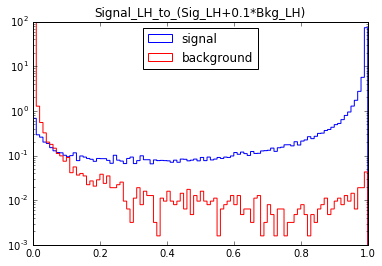

In [32]:
_=plt.hist(sigSoft,bins=100, histtype='step', label='signal', normed = 1)
                           
_=plt.hist(bkgSoft,bins=100, histtype='step', color= 'red', label='background', normed = 1)

_=plt.yscale('log')

_=plt.legend(loc='upper center')

_=plt.title('Signal_LH_to_(Sig_LH+0.1*Bkg_LH)')

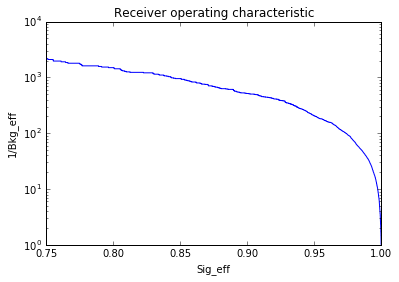

In [33]:
fpr_MEM, tpr_MEM, thresholds_MEM = roc_curve(y_test,softTarget)
plt.figure()
##plt.plot(fpr, tpr)
plt.plot(tpr_MEM, 1/fpr_MEM)
plt.xlim([0.75, 1])
plt.ylim([1, 10000])
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.yscale('log')
plt.show()

In [34]:
sigTrain_ = {
        'X' : X_train,
        'y' : y_train,
        'signal_lh' : signal_lh_train
    }
bkgTrain_ = {
            'X' : X_train,
            'y' : y_train,
            'bkg_lh' : bkg_lh_train
    }
sigTest_ = {
            'X' : X_test,
            'y' : y_test,
            'signal_lh' : signal_lh_test
    }
bkgTest_ = {
            'X' : X_test,
            'y' : y_test,
            'bkg_lh' : bkg_lh_test
    }

In [35]:
SAMPLE_PATH2 = os.path.join('/home/debo/debo_dark_mem')

In [36]:
io.save(os.path.join(SAMPLE_PATH2, 'MEM-A-db' + 'sig' + 'wBjetDotProduct' + '.h5'), sigTrain_)

In [37]:
io.save(os.path.join(SAMPLE_PATH2, 'MEM-B-db' + 'sig' + 'wBjetDotProduct' + '.h5'), sigTest_)

In [38]:
io.save(os.path.join(SAMPLE_PATH2, 'MEM-A-db' + 'bkg' + 'wBjetDotProduct' + '.h5'), bkgTrain_)

In [39]:
io.save(os.path.join(SAMPLE_PATH2, 'MEM-B-db' + 'bkg' + 'wBjetDotProduct' + '.h5'), bkgTest_)